In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
#import xgboost as xgb
from sklearn.metrics import mean_absolute_error

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn import preprocessing

In [3]:
train=pd.read_csv('train.csv', ',')
test=pd.read_csv('test.csv', ',')

In [4]:
train.isnull().values.any(),train.isnull().sum().sum()

(False, 0)

In [5]:
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


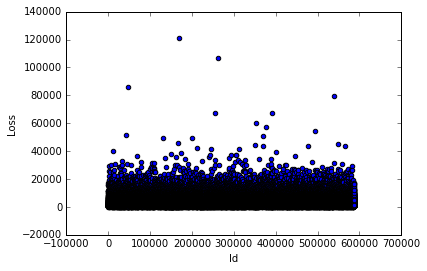

In [6]:
#Scatter plot of Id vs Loss in $
data = train[['id','loss']].values
#Plot part
plt.scatter(data[:,0],data[:,1]);
plt.xlabel('Id');
plt.ylabel('Loss');

In [7]:
train.shape, test.shape

((188318, 132), (125546, 131))

numpy.ndarray

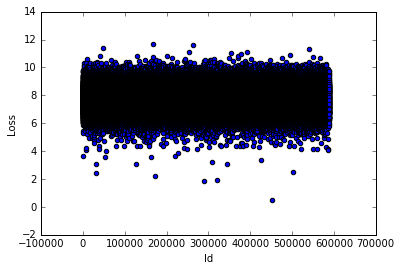

In [8]:
#Scatter plot of Id vs Loss in $
data = train[['id','loss']].values

#Plot part
plt.scatter(data[:,0],np.log1p(data[:,1]));
plt.xlabel('Id');
plt.ylabel('Loss');
type(data)

Dropping id and loss field from train data and just loss field from test data

Concat train and test data so as to avoid mismatch of number of features after applying pandas_dataframe.get_dummies

In [9]:
x_train = train.loc[:,'cat1':'cont14']
#train_test_data = pd.concat((train.loc[:,'cat1':'cont14'],test.loc[:,'cat1':'cont14']))
x_train.shape, type(x_train)

((188318, 130), pandas.core.frame.DataFrame)

Assume target column loss is in $, normalize the data by taking log1p  
pd.DataFrame converts train_target back to Dataframe, I don't want it in series format

In [10]:

t_train = pd.DataFrame(np.log1p(train.loc[:, 'loss'].values))
#train_target=np.log(train['loss'].ravel())
type(t_train)

pandas.core.frame.DataFrame

In [11]:
'''Get names of the features of entire data'''
feature_names = list(x_train.columns.values)
len(feature_names), type(feature_names)

(130, list)

Find categorical columns using below snippet

In [12]:
categorical_columns = []
for column in x_train.columns.values:
    if x_train[column].dtype == 'object':
        categorical_columns.append(column)
    

In [13]:
len(categorical_columns)

116

In [14]:
train_continuous = x_train.drop(categorical_columns, axis=1)
train_categorical = x_train[categorical_columns]
train_continuous.shape, train_categorical.shape

((188318, 14), (188318, 116))

In [15]:
test_continuous = test.drop(categorical_columns, axis=1)
test_continuous = test_continuous.drop('id', axis =1)
test_categorical = test[categorical_columns]
test_continuous.shape, test_categorical.shape

((125546, 14), (125546, 116))

Checking if there is any missing values in train continuous dataset

In [16]:
for column in train_continuous.columns.values:
    if train_continuous[column].isnull().sum() > 0:
        print column + "\t" + str(train_continuous[column].isnull().sum())

Try correlation between continuous columns 
Pending?

In [17]:
from scipy.stats import pearsonr
train_continuous_correlation = train_continuous.corr(method='pearson')
numColumns = train_continuous.shape[1]
correlation_list = []
for i in range(numColumns):
    for j in range(i+1, numColumns-1):
        correlation_list.append([train_continuous_correlation.iloc[i,i+1],i,i+1])

#Sort to show higher ones first            
s_corr_list = sorted(correlation_list,key=lambda x: -abs(x[0]))

Below pairs have string correlation between them and we can use PCA for them to reduce feature set

In [18]:
len(s_corr_list)

78

Check missing values in categorical train dataset

In [19]:
for column in train_categorical.columns.values:
    if train_categorical[column].isnull().sum() > 0:
        print column + "\t" + str(train_categorical[column].isnull().sum())
train_categorical.shape

(188318, 116)

In [20]:
train_test_categorical = pd.concat((train_categorical.loc[:,:],test_categorical.loc[:,:]))
train_test_categorical.shape, train_categorical.shape, test_categorical.shape, type(train_test_categorical)

((313864, 116), (188318, 116), (125546, 116), pandas.core.frame.DataFrame)

In [21]:

for column in train_categorical.columns.values:
    if train_categorical[column].nunique() != test_categorical[column].nunique():
        print column
        uniqueTrainCatSet = set(train_categorical[column].unique())
        uniqueTestCatSet = set(test_categorical[column].unique())
        removeTrain = uniqueTrainCatSet - uniqueTestCatSet
        removeTest = uniqueTestCatSet - uniqueTrainCatSet
        
        remove = removeTrain.union(removeTest)
        
        def filterCat(x):
            if x in remove:
                return np.nan
            return x
        
        train_test_categorical[column] = train_test_categorical[column].apply(lambda x: filterCat(x), 1)
    train_test_categorical[column] = pd.factorize(train_test_categorical[column].values, sort=True)[0]

cat90
cat92
cat96
cat99
cat101
cat102
cat103
cat105
cat106
cat109
cat110
cat113
cat114
cat116


In [23]:
for column in train_categorical.columns.values:
    train_test_categorical[column] = pd.factorize(train_test_categorical[column].values, sort=True)[0]
train_test_categorical.shape

(313864, 116)

In [24]:
type(train_test_categorical), train_test_categorical.shape

(pandas.core.frame.DataFrame, (313864, 116))

In [25]:
train_categorical = train_test_categorical.iloc[:train_categorical.shape[0],:]
test_categorical = train_test_categorical.iloc[train_categorical.shape[0]:,:]
train_categorical.shape, test_categorical.shape

((188318, 116), (125546, 116))

In [26]:
x_train_new = train_continuous.join(train_categorical)
x_train_new.shape, train_continuous.shape, train_categorical.shape, t_train.shape

((188318, 130), (188318, 14), (188318, 116), (188318, 1))

In [27]:
x_test = test_continuous.join(test_categorical)
x_test.shape

(125546, 130)

In [28]:
x_train_new.loc[:9999,:].shape, t_train.loc[:10000].values.ravel().shape

((10000, 130), (10001,))

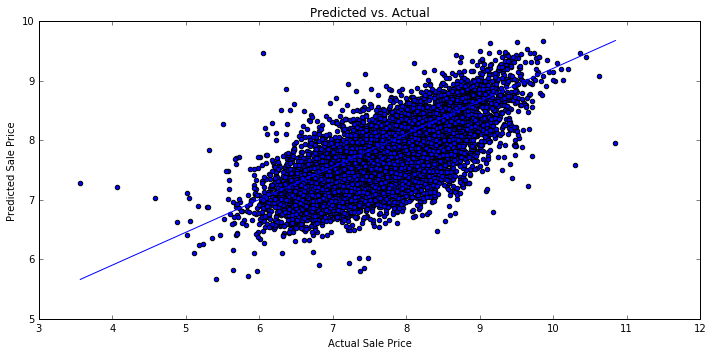

In [29]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

X_train1, X_test1, y_train1, y_test1 = train_test_split(x_train_new.loc[:79999,:].values, t_train.values.ravel()[:80000], test_size=0.1)
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
#clf = LinearRegression(n_jobs=-1)

clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

#y_test1 = y_test1
plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_pred), max(y_pred)])
plt.tight_layout()

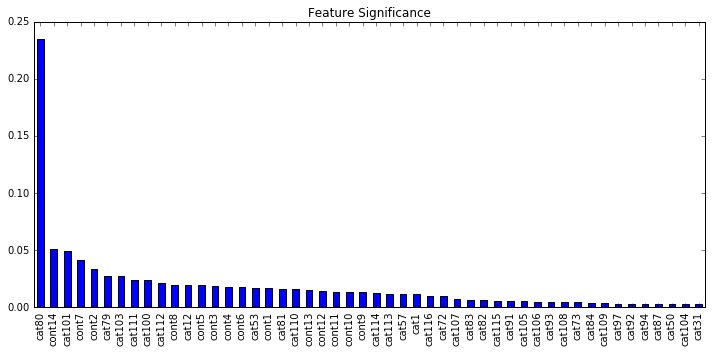

In [30]:
'''Get names of the features of entire data'''
names = list(x_train_new.columns.values)
'''Get the feature importance of RandomForest'''
importances = clf.feature_importances_
#print len(importance)
sorted_importances = pd.Series(importances, index = x_train_new.columns).sort_values(ascending=False)
sorted_importances = pd.Series(sorted_importances)
plt.figure(figsize=(10, 5))
sorted_importances.head(50).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
print "RMSE", sqrt(mean_squared_error(y_test1, y_pred, multioutput='raw_values'))
print "MAE", mean_absolute_error(y_test1, y_pred)

RMSE 0.570136852624
MAE 0.445129598609


In [32]:
y_pred = clf.predict(x_test)
y_pred

array([ 7.53944322,  7.53893204,  9.1588104 , ...,  7.77685955,
        6.69762202,  8.06863845])

In [33]:
type(y_pred)

numpy.ndarray

In [32]:
np.savetxt("result.csv", y_pred)